<a href="https://colab.research.google.com/github/C191248TahiaHoque/Neural-Network-Projects/blob/main/NN_Group_05_Predict_Electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as state
import pprint
%matplotlib inline

import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # special style template for matplotlib, highly useful for visualizing time series data
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df=pd.read_csv("Electric_Production.csv")
df.head(400)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
...,...,...
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212


**Data Preprocessing**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [ ]:
# Information about Dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB
None


In [ ]:
# Describing the dataset
print(df.describe())

       Consumption
count   397.000000
mean     88.847218
std      15.387834
min      55.315100
25%      77.105200
50%      89.779500
75%     100.524400
max     129.404800


In [ ]:
df.loc[~df.index.duplicated(), :]

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [ ]:
# NULL Values
df.isnull().sum()

Consumption    0
dtype: int64

**1.Visualizing the time series**

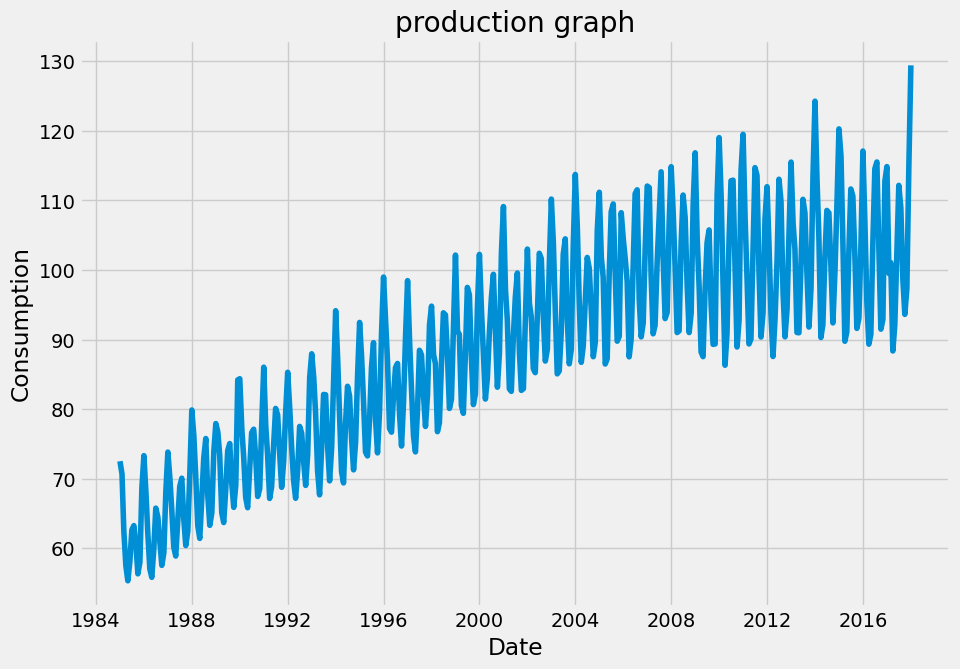

In [ ]:
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

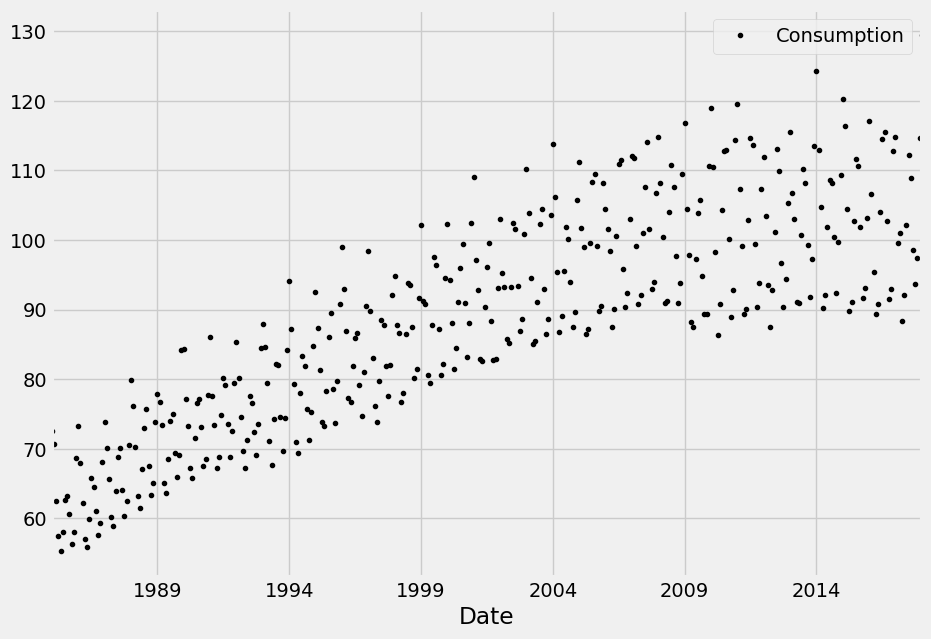

In [ ]:
df.plot(style='k.')
plt.show()

<Axes: ylabel='Density'>

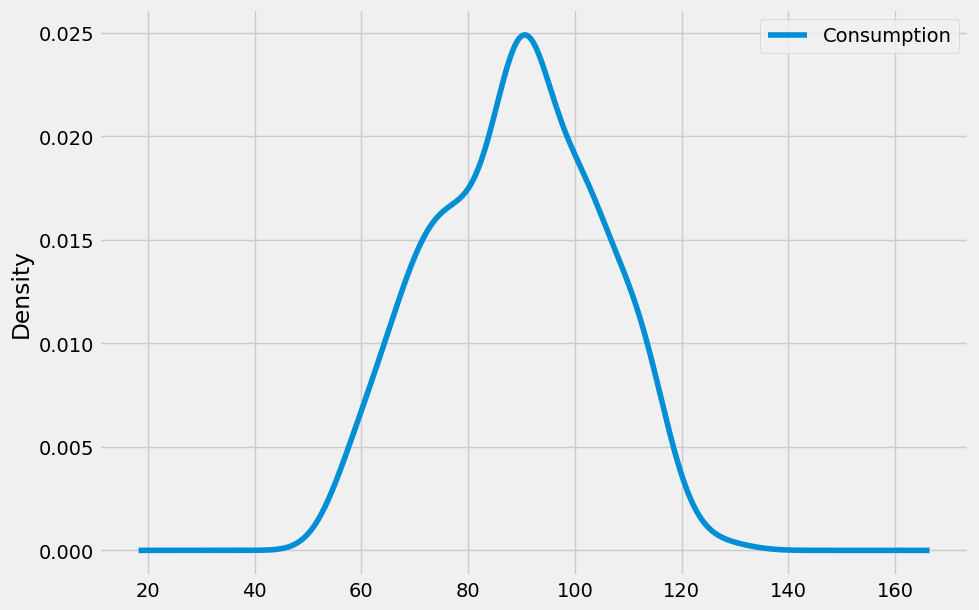

In [ ]:
df.plot(kind='kde')

**Histogram**

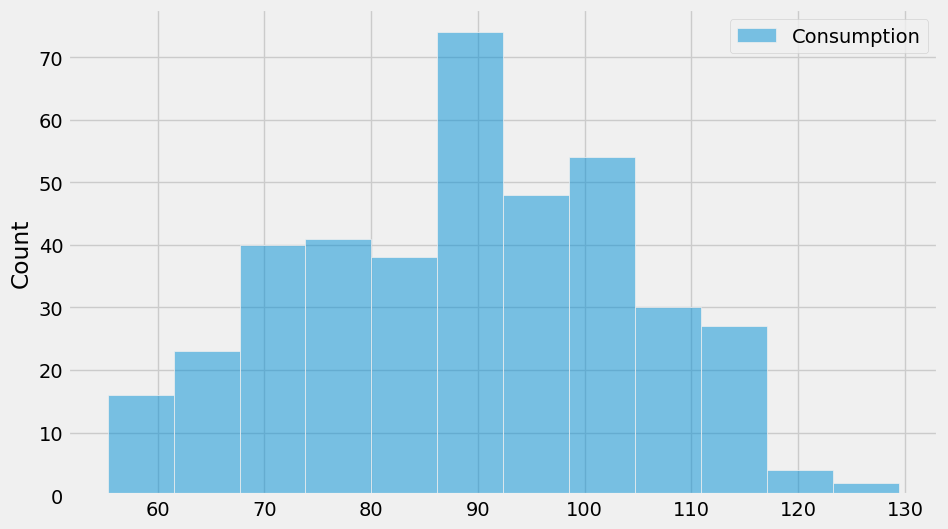

In [ ]:
sns.histplot(df).figure.set_size_inches(10, 6)

**Histogram and Distribution chart**

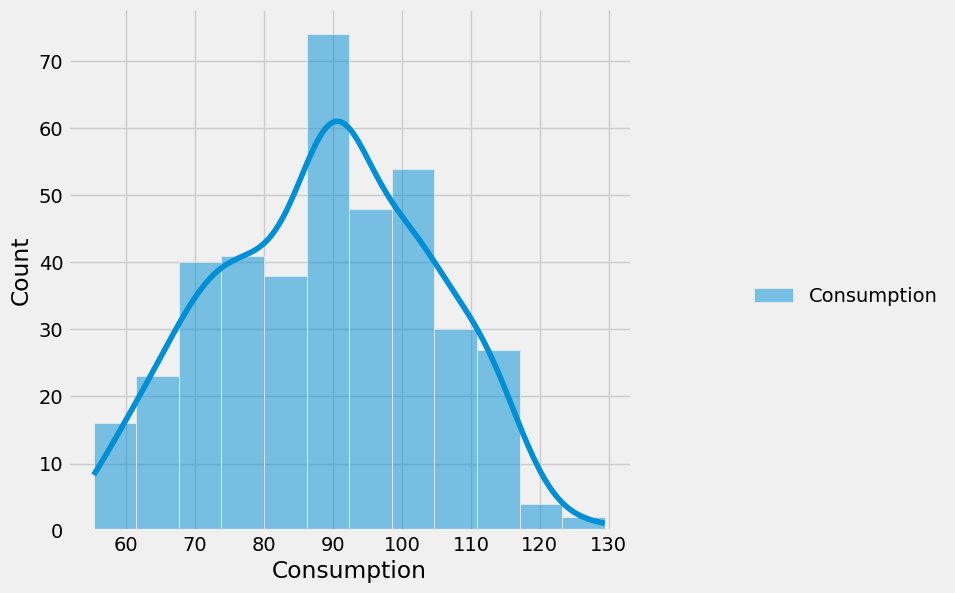

In [ ]:
sns.displot(df, kde=True).figure.set_size_inches(10, 6)
plt.xlabel('Consumption')
plt.show()

We can observe a near-normal distribution(bell-curve) over consumption values.A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

**Level**: The average value in the series.

**Trend**: The increasing or decreasing value in the series.

**Seasonality**: The repeating short-term cycle in the series.

**Noise**: The random variation in the series.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

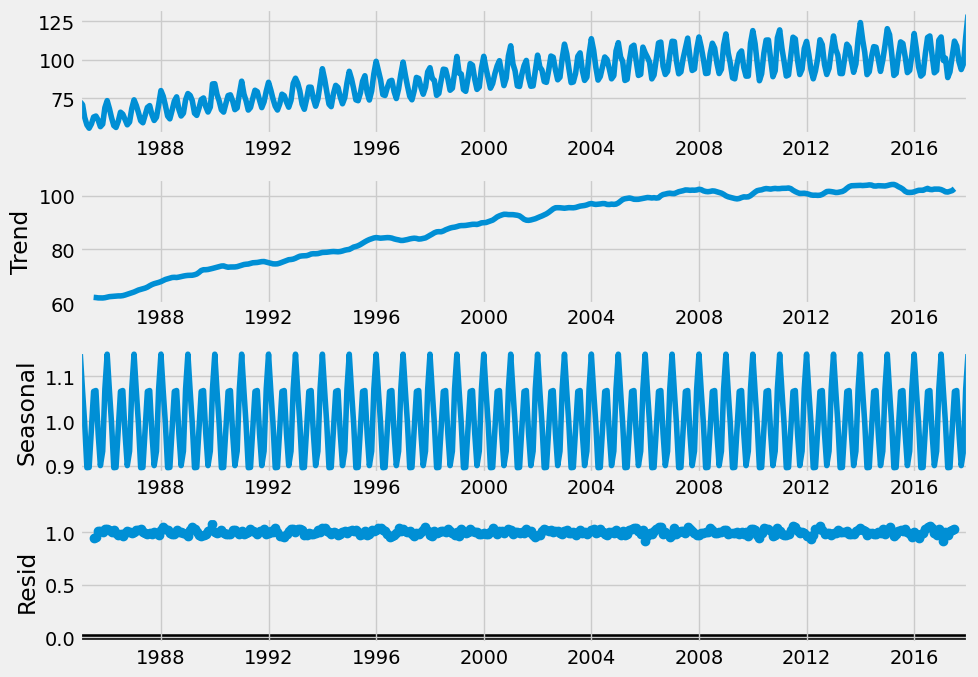

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

**2. Stationarising the time series.**

First, we need to check if a series is stationary or not.

ADF (Augmented Dickey-Fuller) Test
The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

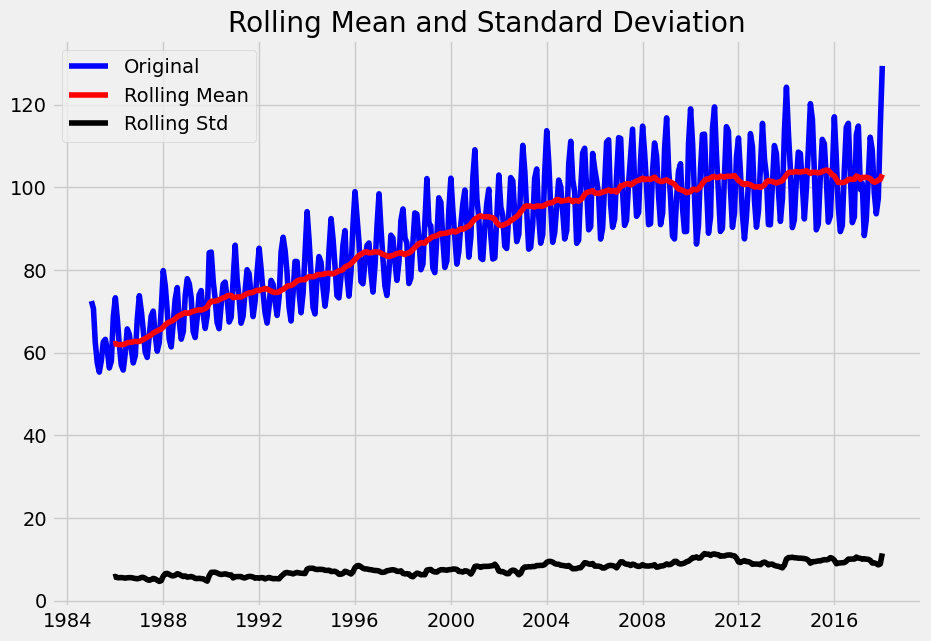

Results of dickey fuller test
Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #perform dickey fuller test
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.The test statistics is greater than the critical values. so the data is non-stationary.

To get a stationary series, we need to eliminate the trend and seasonality from the series.

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series.

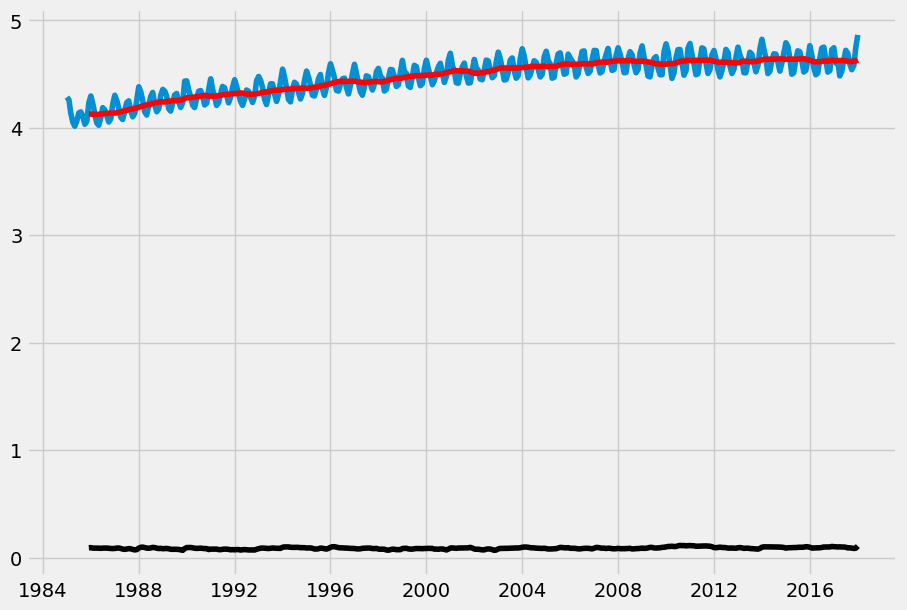

In [ ]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.

In [ ]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

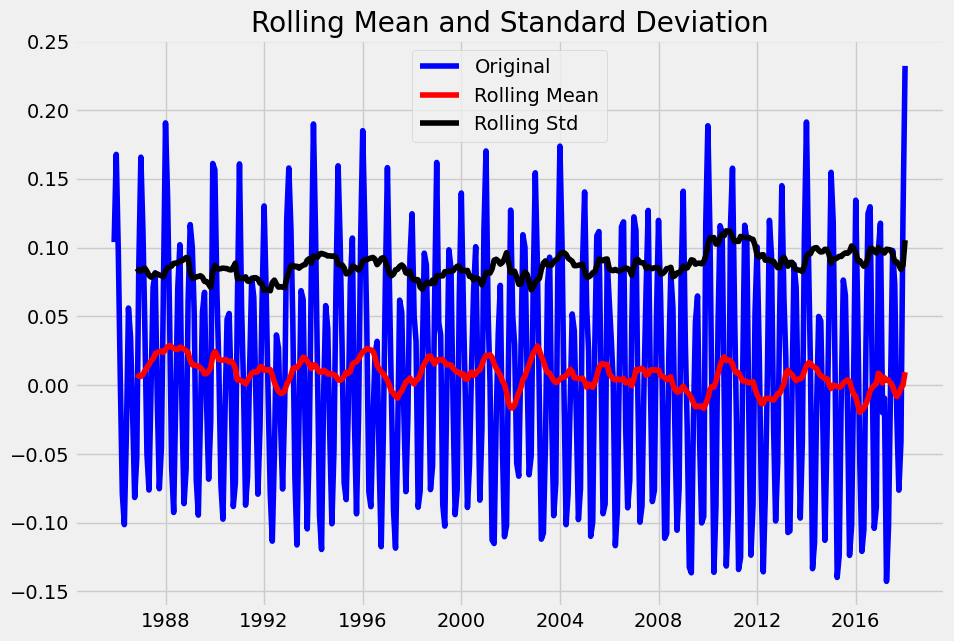

Results of dickey fuller test
Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


In [ ]:
test_stationarity(df_log_moving_avg_diff)

From the above graph, we observed that the data attained stationarity.

One of the modules is completed as we came to a conclusion. We need to check the weighted average, to understand the trend of the data in time series. Take the previous log data and to perform the following operation.



In [ ]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

The exponential moving average (EMA) is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period.

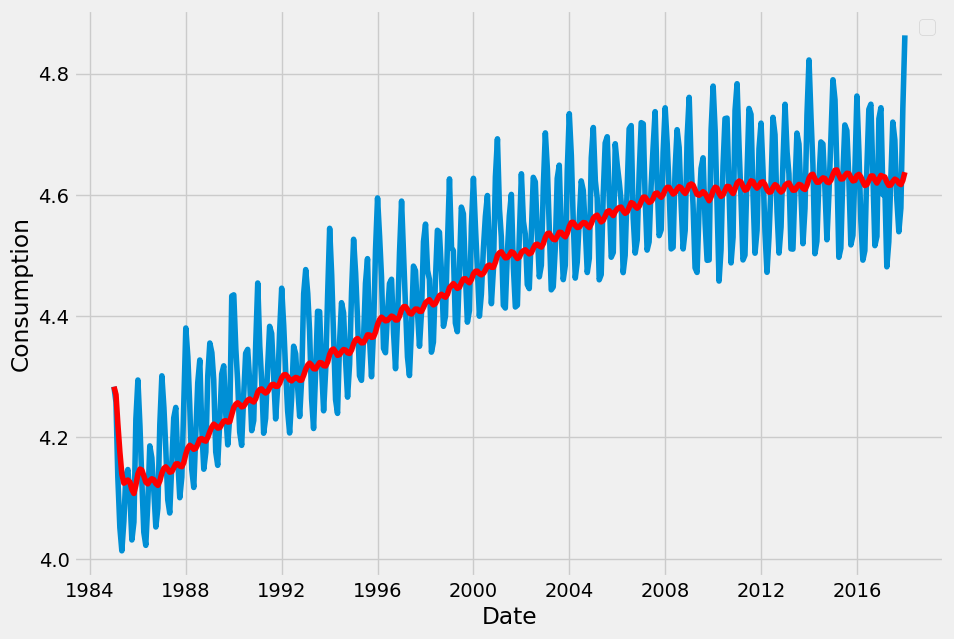

In [ ]:
plt.plot(df_log)
plt.plot(weighted_average, color='red')
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
plt.legend()
plt.show(block =False)

Previously we subtracted df_log with moving average, now take the same df_log and subtract with weighted_average and perform the Dickey-Fuller test (ADFT) once again.

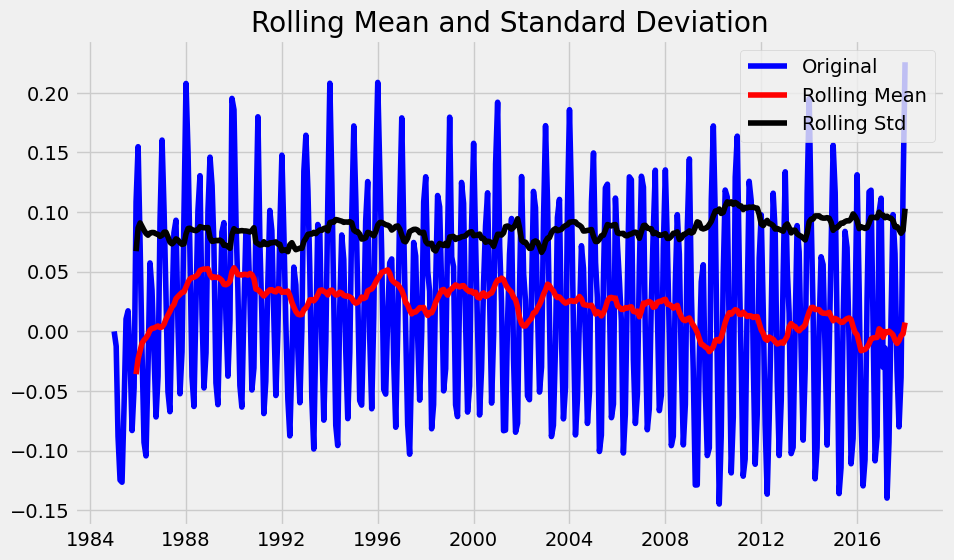

Results of dickey fuller test
Test Statistics                 -3.251531
p-value                          0.017189
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [ ]:
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

From the above graph, we observed that the data attained stationarity. We also see that the test statistics and critical value is relatively equal.

There can be cases when there is a high seasonality in the data. In those cases, just removing the trend will not help much. We need to also take care of the seasonality in the series. One such method for this task is differencing.

Differencing is a method of transforming a time series dataset.

Differencing is performed by subtracting the previous observation from the current observation.

Perform the Dickey-Fuller test (ADFT) once again.

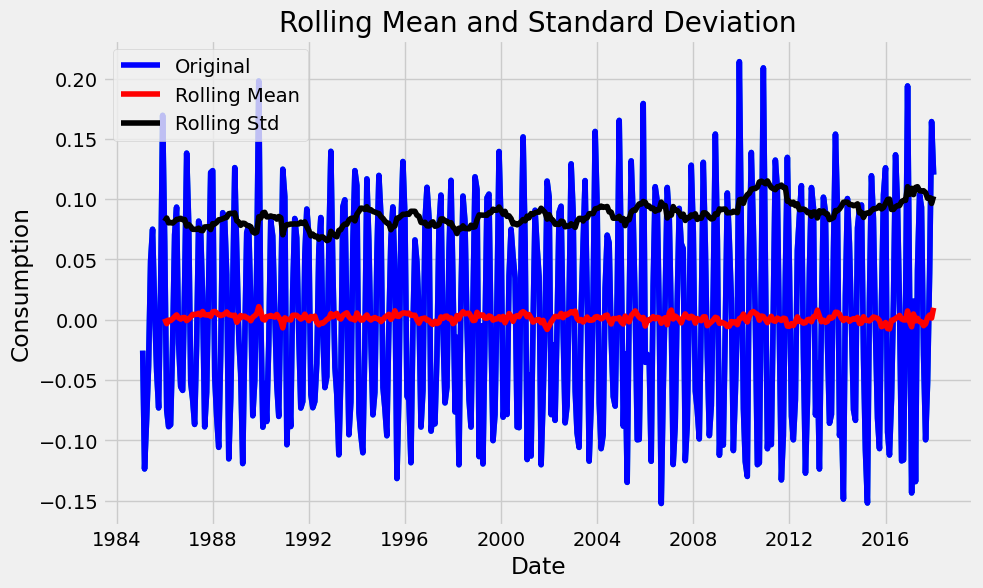

Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


In [ ]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

The next step is to perform decomposition which provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components

In [ ]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 3.3 MB/s eta 0:00:00


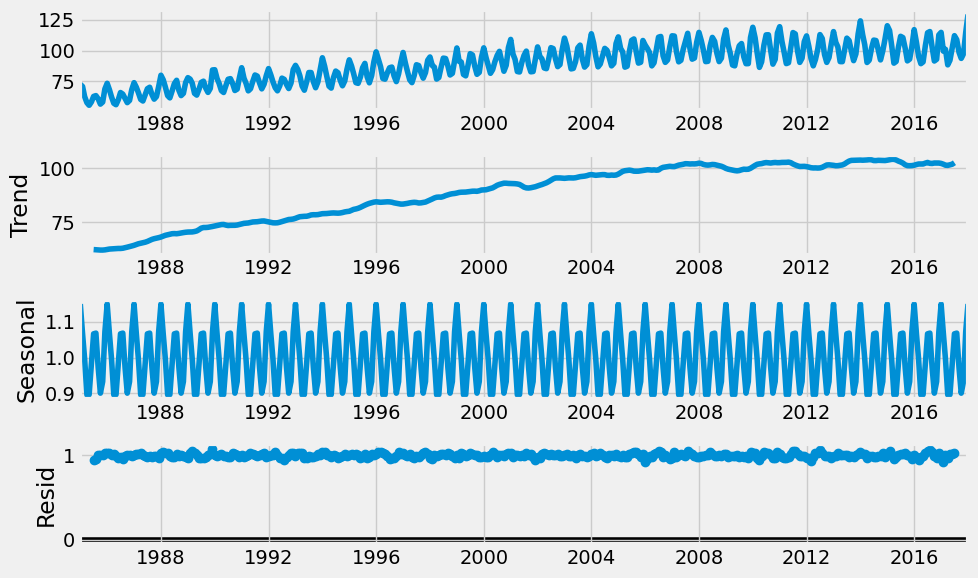

In [ ]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()

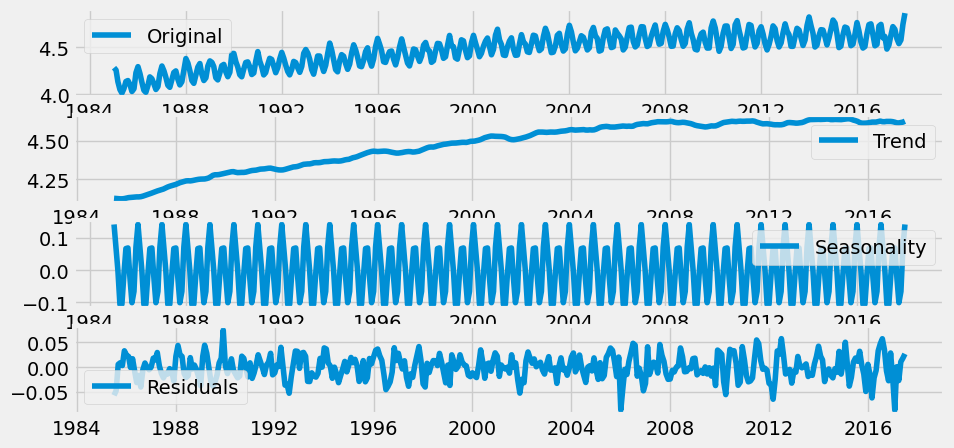

In [ ]:
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(df_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

**3. Finding the best parameters for our model**

Before we go on to build our forecasting model, we need to determine optimal parameters for our model. For those optimal parameters, we need ACF and PACF plots.

A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

p → Number of autoregressive terms, d → Number of nonseasonal differences needed for stationarity, and q → Number of lagged forecast errors in the prediction equation.

**Autocorrelation Function(ACF)**
Statistical correlation summarizes the strength of the relationship between two variables. Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.
**Partial Autocorrelation Function(PACF)**
A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.


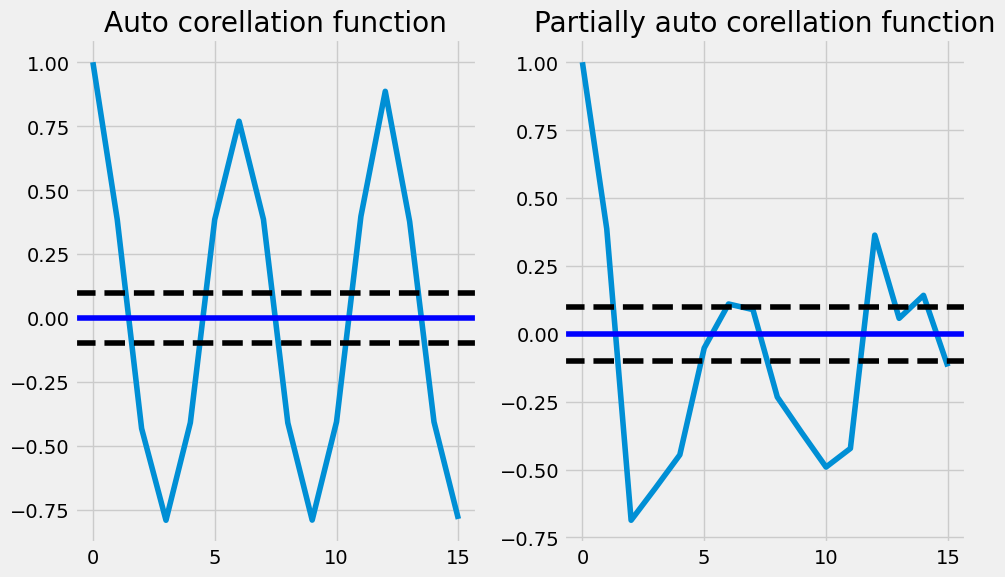

In [ ]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf)
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf)
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()


**Function for checking the stationarity of Time Series**

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    sns.lineplot(y=df,x=df.index,)
    df.rolling(window=12).mean().plot()
    df.rolling(window=12).std().plot()
    result=adfuller(df,autolag="AIC")

    print(f"ADF Statistics: {result[0]}")
    print(f"p value: {result[1]}")

    for key,value in result[4].items():
        print(f"Critical Value {key}: {value}")

    print("\n\n")

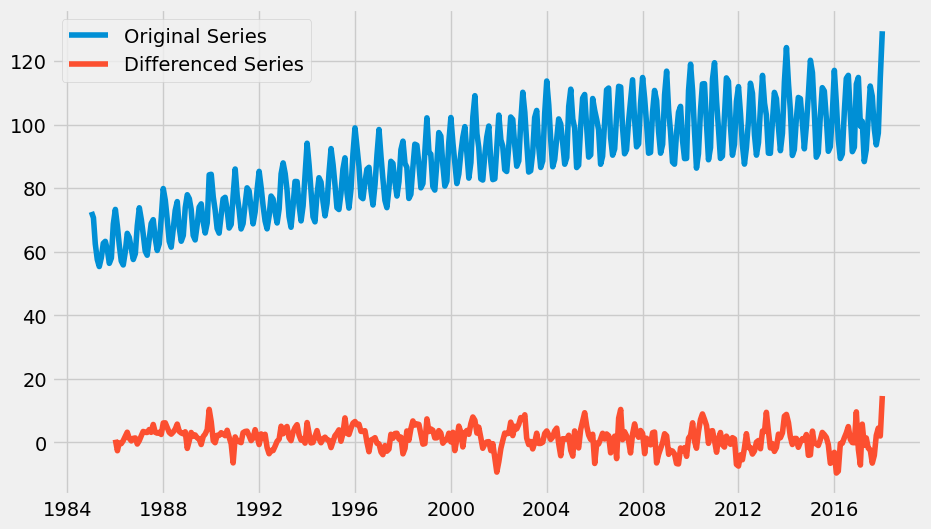

In [ ]:
diff_12=df["Consumption"].diff(12).dropna()

plt.plot(df["Consumption"],label="Original Series")
plt.plot(diff_12,label="Differenced Series")
plt.legend(loc="upper left")

ADF Statistics: -2.256990350047235
p value: 0.1862146911658712
Critical Value 1%: -3.4476305904172904
Critical Value 5%: -2.869155980820355
Critical Value 10%: -2.570827146203181





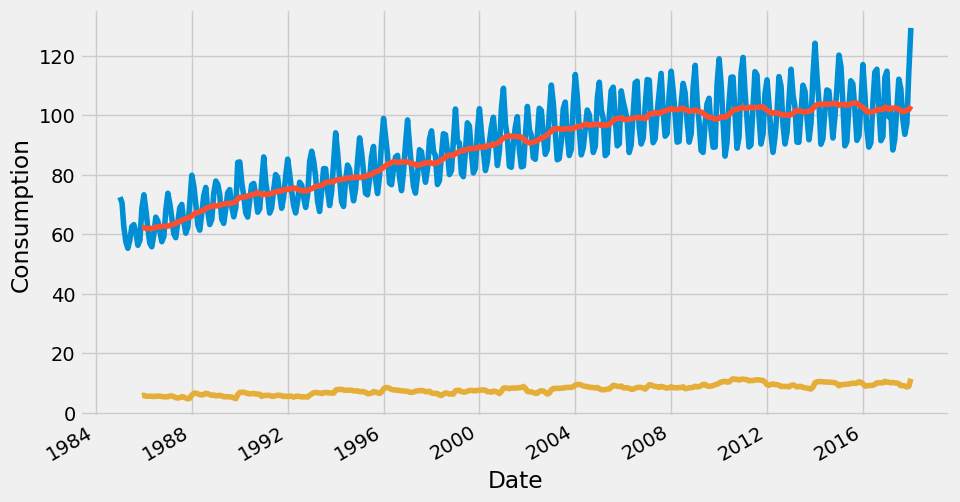

In [ ]:
check_stationarity(df["Consumption"])

**Finding Best Parameter**

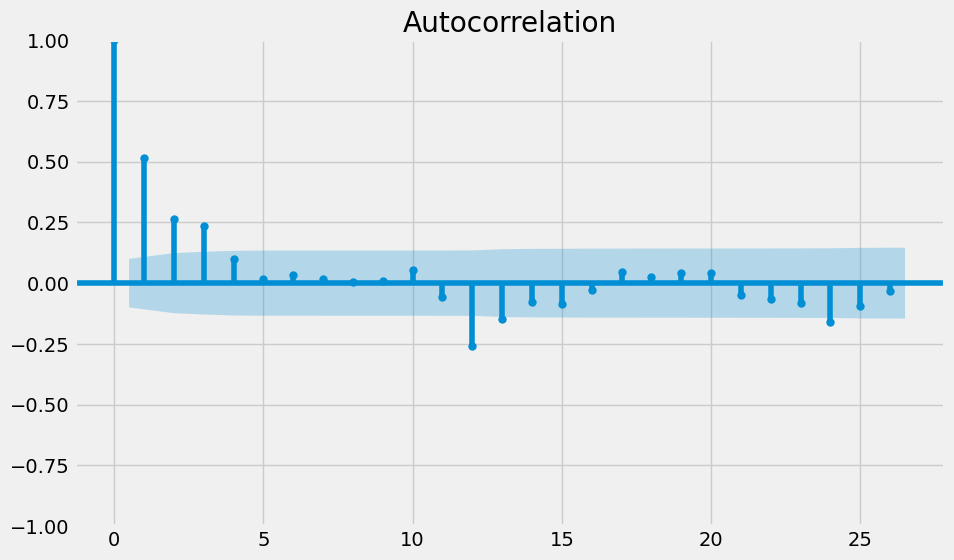

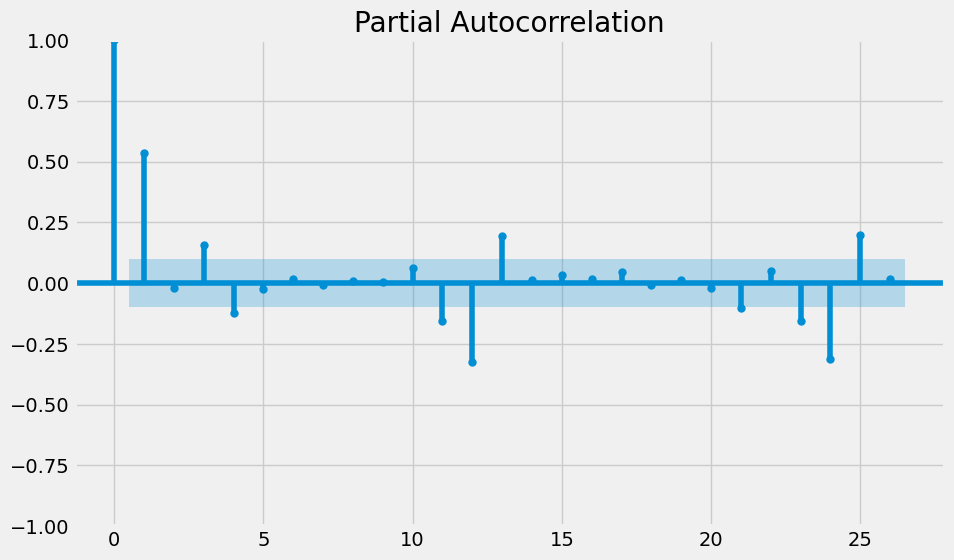

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(diff_12);
plot_pacf(diff_12,method="ols");

**4. Prepare data for training the RNN models**

In [ ]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])

    #1 last 60 days are going to be used in test
    X_test = X_train[350:]
    y_test = y_train[350:]

    #2 first 250 days are going to be used in training
    X_train = X_train[:350]
    y_train = y_train[:350]

    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (350, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [ ]:
#create train, test data
seq_len = 5  #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (350, 5, 1)
y_train.shape =  (350,)
X_test.shape =  (42, 5, 1)
y_test.shape =  (42,)


**5. Build a RNN model**

In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(60,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(60,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(60,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 5, 60)             3720      
                                                                 
 dropout_3 (Dropout)         (None, 5, 60)             0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 5, 60)             7260      
                                                                 
 dropout_4 (Dropout)         (None, 5, 60)             0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 60)                7260      
                                                                 
 dropout_5 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=27, batch_size=28)

Epoch 1/27
13/13 [==============================] - 5s 7ms/step - loss: 48.7449
Epoch 2/27
13/13 [==============================] - 0s 8ms/step - loss: 43.4925
Epoch 3/27
13/13 [==============================] - 0s 7ms/step - loss: 46.2926
Epoch 4/27
13/13 [==============================] - 0s 7ms/step - loss: 56.4134
Epoch 5/27
13/13 [==============================] - 0s 8ms/step - loss: 44.0055
Epoch 6/27
13/13 [==============================] - 0s 8ms/step - loss: 47.2399
Epoch 7/27
13/13 [==============================] - 0s 9ms/step - loss: 44.9024
Epoch 8/27
13/13 [==============================] - 0s 8ms/step - loss: 44.8014
Epoch 9/27
13/13 [==============================] - 0s 8ms/step - loss: 46.8284
Epoch 10/27
13/13 [==============================] - 0s 8ms/step - loss: 54.4651
Epoch 11/27
13/13 [==============================] - 0s 8ms/step - loss: 49.3555
Epoch 12/27
13/13 [==============================] - 0s 8ms/step - loss: 47.6658
Epoch 13/27
13/13 [==================

Let's check r2 score for the values predicted by the above trained SIMPLE RNN model

In [ ]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

2/2 [==============================] - 1s 8ms/step
R2 Score of RNN model =  0.6351756343680008


Let's compare the actual values vs predicted values by plotting a graph We see that the predcited values are close to the actual values meaning the RNN model is performing well in predicting the sequence.

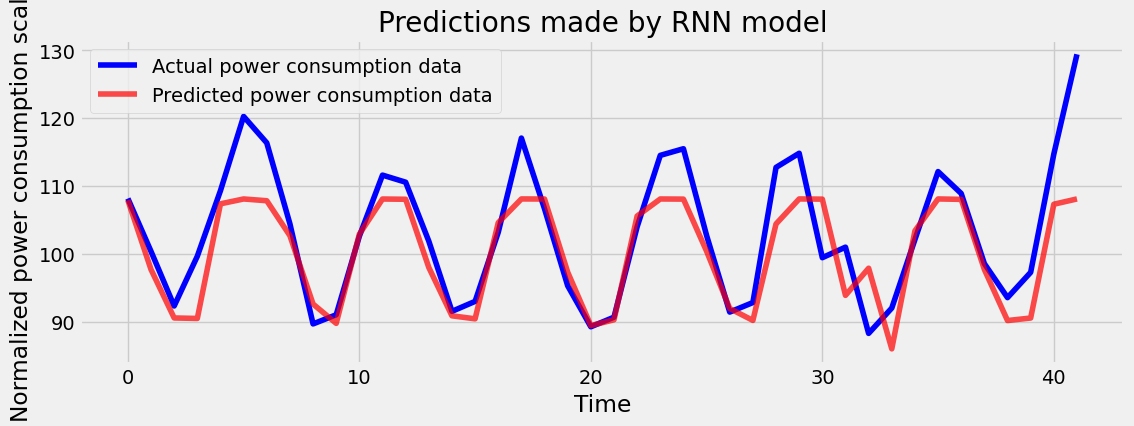

In [ ]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(12,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='red',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

plot_predictions(y_test, rnn_predictions, "Predictions made by RNN model")

**6. Build an LSTM model**

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(50,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(50,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(50,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout_6 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_7 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=100)

Epoch 1/10
4/4 [==============================] - 10s 20ms/step - loss: 40.7078
Epoch 2/10
4/4 [==============================] - 0s 22ms/step - loss: 47.7849
Epoch 3/10
4/4 [==============================] - 0s 19ms/step - loss: 34.2105
Epoch 4/10
4/4 [==============================] - 0s 19ms/step - loss: 36.6637
Epoch 5/10
4/4 [==============================] - 0s 20ms/step - loss: 39.1867
Epoch 6/10
4/4 [==============================] - 0s 23ms/step - loss: 37.0517
Epoch 7/10
4/4 [==============================] - 0s 20ms/step - loss: 38.9967
Epoch 8/10
4/4 [==============================] - 0s 21ms/step - loss: 37.1012
Epoch 9/10
4/4 [==============================] - 0s 20ms/step - loss: 36.6648
Epoch 10/10
4/4 [==============================] - 0s 19ms/step - loss: 38.6638


Let's check r2 score for the values predicted by the above trained LSTM mode

In [ ]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

2/2 [==============================] - 3s 11ms/step
R^2 Score of LSTM model =  0.7554281841875017


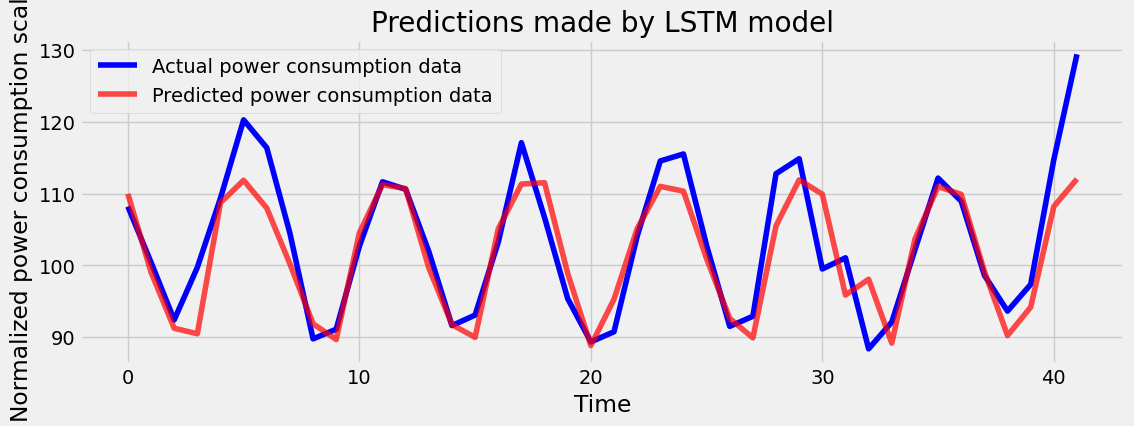

In [ ]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

**7. Compare predictions made by simple RNN, LSTM model by plotting data in a single graph**

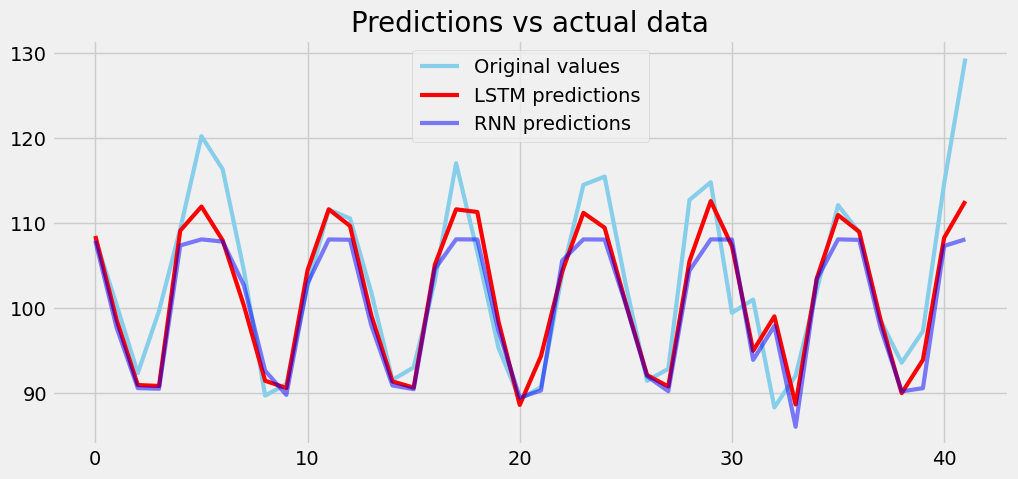

In [ ]:
plt.figure(figsize=(11,5))

plt.plot(y_test, c="skyblue", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

**8.Consumtion Time series for year ,month and day of the week**

In [ ]:
df1 = df
df1["Year"]=df1.index.year
df1["Month"]=df1.index.month
df1["Day_of_week"]=df1.index.dayofweek
df1.head()

,Consumption,Year,Month,Day_of_week
Date,,,,
1985-01-01,72.5052,1985,1,1
1985-02-01,70.6720,1985,2,4
1985-03-01,62.4502,1985,3,4
1985-04-01,57.4714,1985,4,0
1985-05-01,55.3151,1985,5,2


In [ ]:
print(df.Year.unique(),"\n")
print("Unique Years : ",df.Year.nunique())

[1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018] 

Unique Years :  34


In [ ]:
plt.rcParams.update({"figure.figsize":(12,8)})

<Axes: title={'center': 'Consumption Time Series'}, xlabel='Date', ylabel='Consumption'>

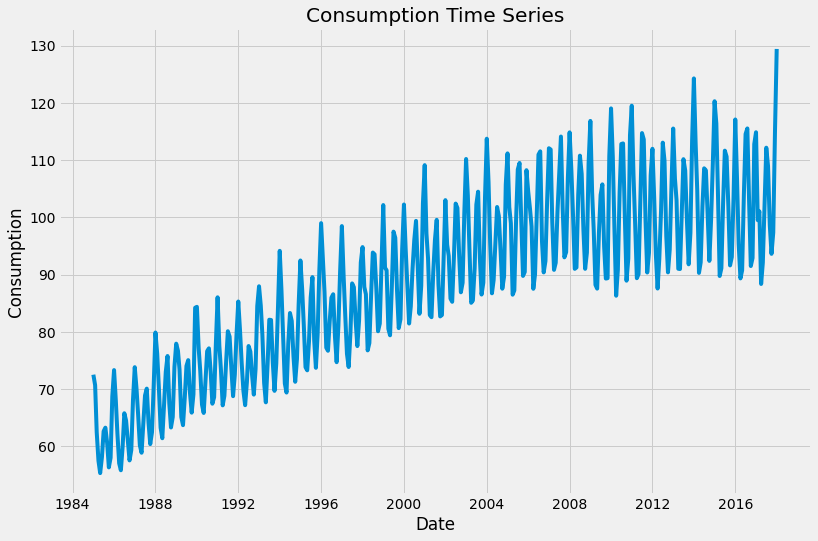

In [ ]:
plt.title("Consumption Time Series")
sns.lineplot(y=df["Consumption"],x=df.index)

<Axes: xlabel='Year', ylabel='Consumption'>

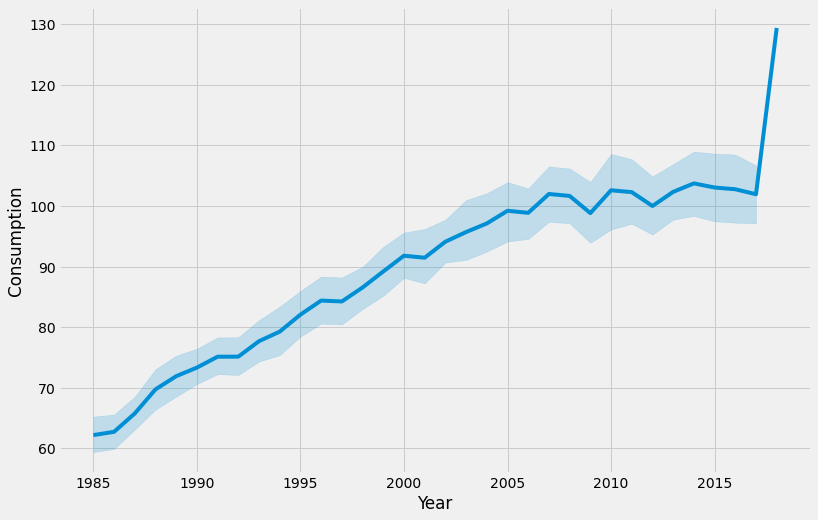

In [ ]:
sns.lineplot(x="Year",y="Consumption",data=df)

**Every year the amount of comsumption increases**

There is an upward trend

**Feature understanding**
In this section, the explore of the distribution of electricity demand with respect the different features, such as year,month and day_of_week. This is a great way to understand the seasonalities in the time series.

<Axes: xlabel='Year', ylabel='Consumption'>

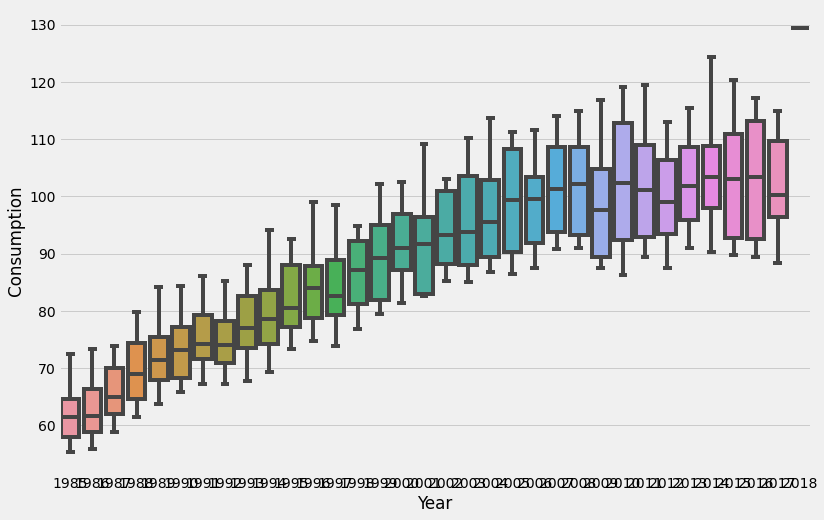

In [ ]:
sns.boxplot(x="Year",y="Consumption",data=df)

**Monthly consumption**

<Axes: xlabel='Month', ylabel='Consumption'>

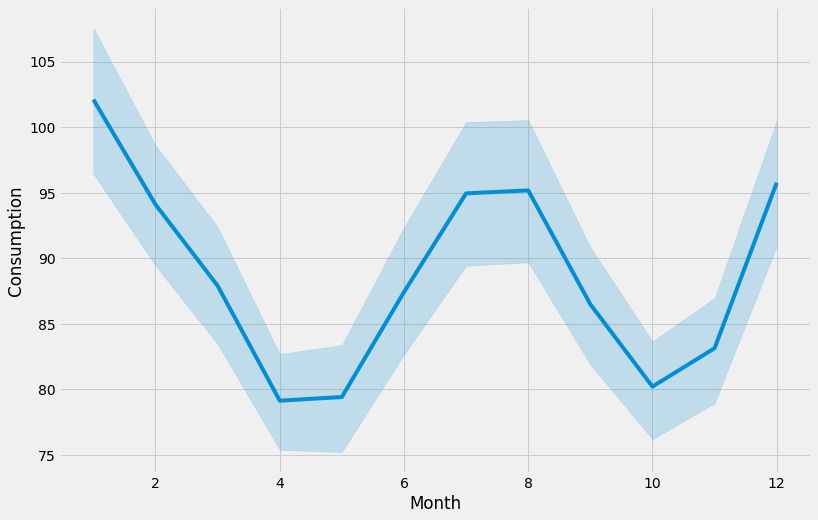

In [ ]:
sns.lineplot(x="Month",y="Consumption",data=df)

**There is strong monthly seasonality**

<Axes: xlabel='Month', ylabel='Consumption'>

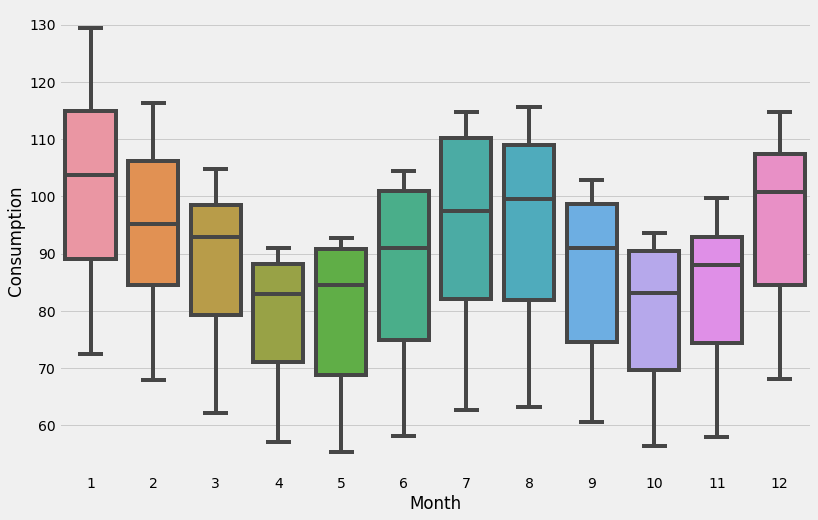

In [ ]:
sns.boxplot(x="Month",y="Consumption",data=df)

**Cosumption of day of the week**

<Axes: xlabel='Day_of_week', ylabel='Consumption'>

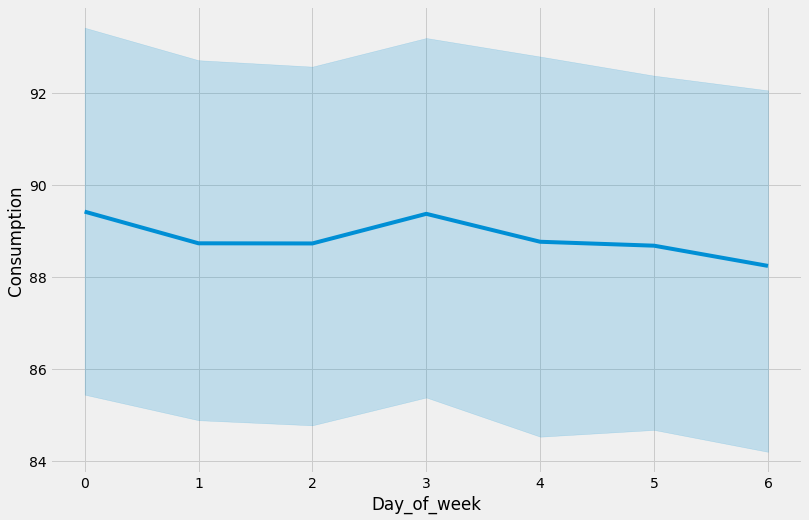

In [ ]:
sns.lineplot(x="Day_of_week",y="Consumption",data=df)

**Consumption is nearly constant on all days of week**

<Axes: xlabel='Day_of_week', ylabel='Consumption'>

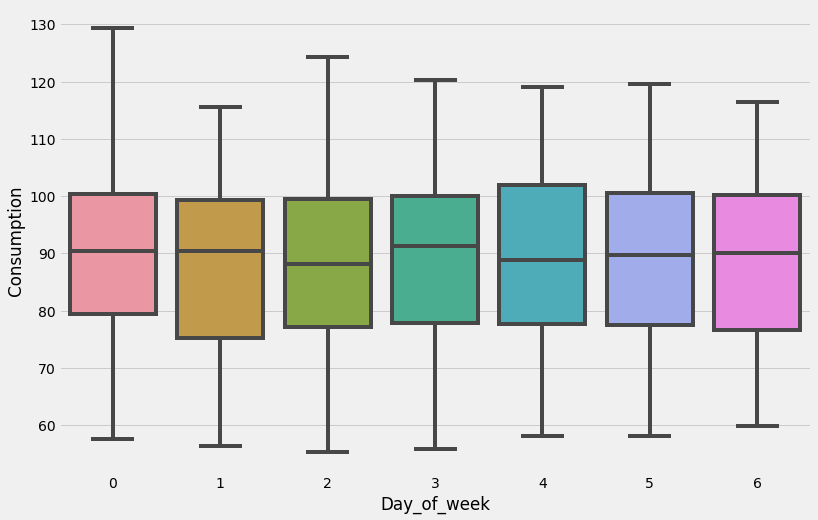

In [ ]:
sns.boxplot(x="Day_of_week",y="Consumption",data=df)

In [ ]:
print(df.describe())

       Consumption         Year       Month  Day_of_week
count   397.000000   397.000000  397.000000   397.000000
mean     88.847218  2001.042821    6.486146     2.997481
std      15.387834     9.560054    3.463071     2.005672
min      55.315100  1985.000000    1.000000     0.000000
25%      77.105200  1993.000000    3.000000     1.000000
50%      89.779500  2001.000000    6.000000     3.000000
75%     100.524400  2009.000000    9.000000     5.000000
max     129.404800  2018.000000   12.000000     6.000000


**Energy Distribution**

Text(0.5, 1.0, 'Energy Distribution')

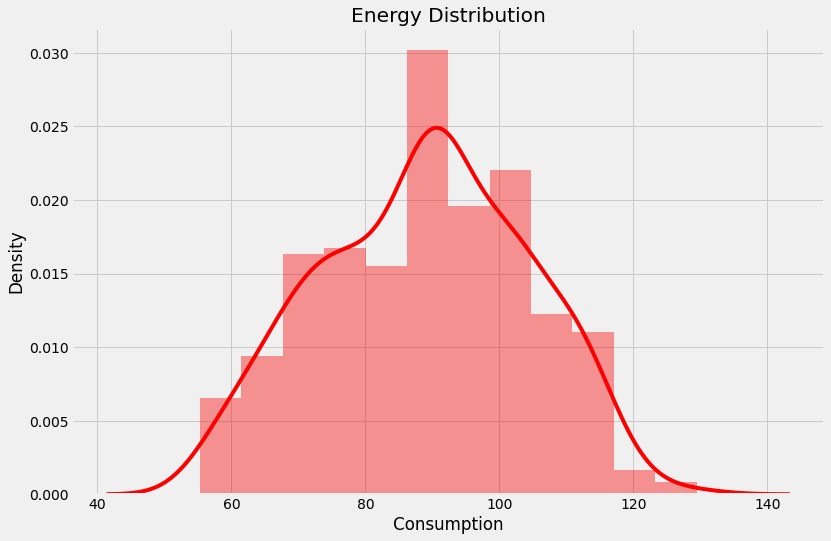

In [ ]:
sns.distplot(df["Consumption"],color = 'r')
plt.title("Energy Distribution")

**Energy consumption with respect to time**

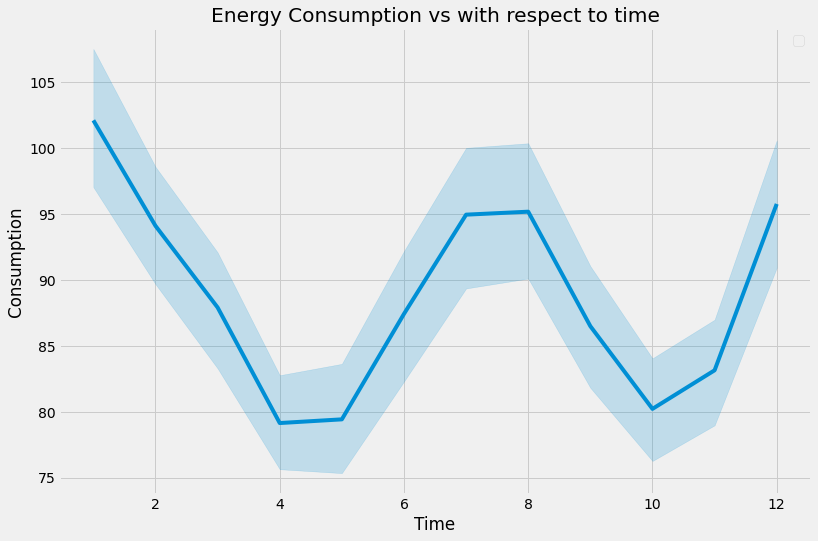

In [ ]:
fig = plt.figure()
ax1= fig.add_subplot(111)

sns.lineplot(x=df["Month"],y=df["Consumption"], data=df)
plt.title("Energy Consumption vs with respect to time")
plt.xlabel("Time")
plt.grid(True, alpha=1)
plt.legend()
